In [1]:
%load_ext rpy2.ipython
from IPython.display import FileLink

In [2]:
%%R
library(dplyr)
library(ggplot2)
#library(rwantshue)
library(grid); library(gridExtra)
library(magrittr)
library(phyloseq)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [4]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeq = 'bulk-core'


#biomFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/OTU_binning/otu_table_wtax.biom'
#metadataFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/metadata_SIP.txt'
#treeFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-6/fasttree/otusn.tree'


# misc
nprocs = 10

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [14]:
%%R -i physeqDir -i physeqSIP

F = '/home/chantal/Chazy/data/phyloseq/bulk-core'
print(F)
physeq = readRDS(F)
physeq.m = physeq %>% sample_data
physeq = prune_samples(!(physeq.m$Full.sample %in% c('12C.PTH.D30.R3_Frac26','12C.NTH.D3.R4.Frac9')),
                           physeq) %>% filter_taxa(function(x) sum(x) > 0, TRUE)

physeq


[1] "/home/chantal/Chazy/data/phyloseq/bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21374 taxa and 185 samples ]
sample_data() Sample Data:       [ 185 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21374 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21374 tips and 21373 internal nodes ]


In [16]:
%%R
mdf = psmelt(physeq)

In [17]:
%%R
head(mdf)

            OTU          Sample Abundance     Full.sample Fraction PrimerF
3811729 OTU.912 Sept.NTH.1.2015      3985 Sept.NTH.1.2015       NA    515f
49351   OTU.103    July15.PTH.2      3020    July15.PTH.2       NA    515f
3555163  OTU.76    July15.PTH.2      2379    July15.PTH.2       NA    515f
318700   OTU.12         O.NTH.3      2020         O.NTH.3       NA    515f
3708680  OTU.85         S.PTR.4      1694         S.PTR.4       NA    515f
3009863 OTU.452    July15.NTH.2      1597    July15.NTH.2       NA    515f
        PrimerR Barcode Rev.index Fwd.index Treatment Day Replicate Pool
3811729    806r      22  acgctact  cgtgagtg      <NA>  NA         1    8
49351      806r     101  cgagagtt  acgtctcg      <NA>  NA         2    4
3555163    806r     101  cgagagtt  acgtctcg      <NA>  NA         2    4
318700     806r     158  cgagcgac  tcgacgag      <NA>  NA         3    5
3708680    806r     155  cgagcgac  agagtcac      <NA>  NA         4    5
3009863    806r     102  cgagagtt  tc

In [18]:
%%R
bulk.df = mdf %>%
    group_by(Land_Management, Sample_Date) %>%
    mutate(relative.abundance = Abundance / sum(Abundance)) %>%
    group_by(OTU, Rank2, Rank3, Rank4, Land_Management, Sample_Date) %>%
    summarize(`Relative Abundance` = mean(relative.abundance)) 

In [19]:
%%R
head(bulk.df)

Source: local data frame [6 x 7]
Groups: OTU, Rank2, Rank3, Rank4, Land_Management [1]

    OTU            Rank2           Rank3            Rank4 Land_Management
  (chr)           (fctr)          (fctr)           (fctr)          (fctr)
1 OTU.1 __Actinobacteria __Micrococcales __Micrococcaceae             NTH
2 OTU.1 __Actinobacteria __Micrococcales __Micrococcaceae             NTH
3 OTU.1 __Actinobacteria __Micrococcales __Micrococcaceae             NTH
4 OTU.1 __Actinobacteria __Micrococcales __Micrococcaceae             NTH
5 OTU.1 __Actinobacteria __Micrococcales __Micrococcaceae             NTH
6 OTU.1 __Actinobacteria __Micrococcales __Micrococcaceae             NTH
Variables not shown: Sample_Date (fctr), Relative Abundance (dbl)


In [26]:
%%R
df.l2fc = read.table("data/l2fc_sparse-maxRejH.txt", sep = '\t', header = TRUE)

df.l2fc %<>% {
    tmp = filter(., padj <= 0.10) %>%
        group_by(OTU) %>%
        summarize(min.p = min(padj)) %>%
        group_by(OTU) %>%
        summarize(S = sum(min.p <= 0.10)) %>%
        select(OTU)
    df.l2fc %>% left_join(tmp)
    }

In [27]:
%%R
head(df.l2fc)

  Substrate Day Replicate Land_Management sparsity_threshold      OTU
1       13C   3         4             NTH               0.25 OTU.2734
2       13C   3         4             NTH               0.25 OTU.1561
3       13C   3         4             NTH               0.25 OTU.3014
4       13C   3         4             NTH               0.25 OTU.2449
5       13C   3         4             NTH               0.25 OTU.1465
6       13C   3         4             NTH               0.25 OTU.2163
  log2FoldChange         p padj    Rank1            Rank2           Rank3
1   -0.743663913 0.9999336    1 Bacteria __Planctomycetes __Phycisphaerae
2   -0.640319982 0.9996644    1 Bacteria __Planctomycetes __Phycisphaerae
3   -0.004259651 0.9817753    1 Bacteria __Planctomycetes __Phycisphaerae
4    0.147798230 0.9635511    1 Bacteria __Planctomycetes __Phycisphaerae
5   -0.460760501 0.9992472    1 Bacteria __Planctomycetes __Phycisphaerae
6   -0.145204500 0.9937535    1 Bacteria __Planctomycetes __Phycis

In [32]:
%%R
FDR = 0.10

minP.df = df.l2fc %>%
    group_by(OTU, Rank3, Rank2, Land_Management, Substrate) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by()

In [29]:
%%R
re = filter(df.l2fc, padj <=0.10) 
unique(re$Rank3)

 [1] __Streptosporangiales              __uncultured_bacterium            
 [3] __Holophagae                       __Alphaproteobacteria             
 [5] __Deltaproteobacteria              __Betaproteobacteria              
 [7] __Gammaproteobacteria              __Micrococcales                   
 [9] __Acidimicrobiia                   __MB-A2-108                       
[11] __Chloroflexales                   __Anaerolineae                    
[13] __TA18                             __Flavobacteria                   
[15] __Candidatus_Chloracidobacterium   __Phycisphaerae                   
[17] __Planctomycetacia                 __Nitrospira                      
[19] __Opitutae                         __Fibrobacteria                   
[21] __OPB35_soil_group                 __Spartobacteria                  
[23] __Verrucomicrobiae                 __DA023                           
[25] __Micromonosporales                __Propionibacteriales             
[27] __Herpetosiphonales 

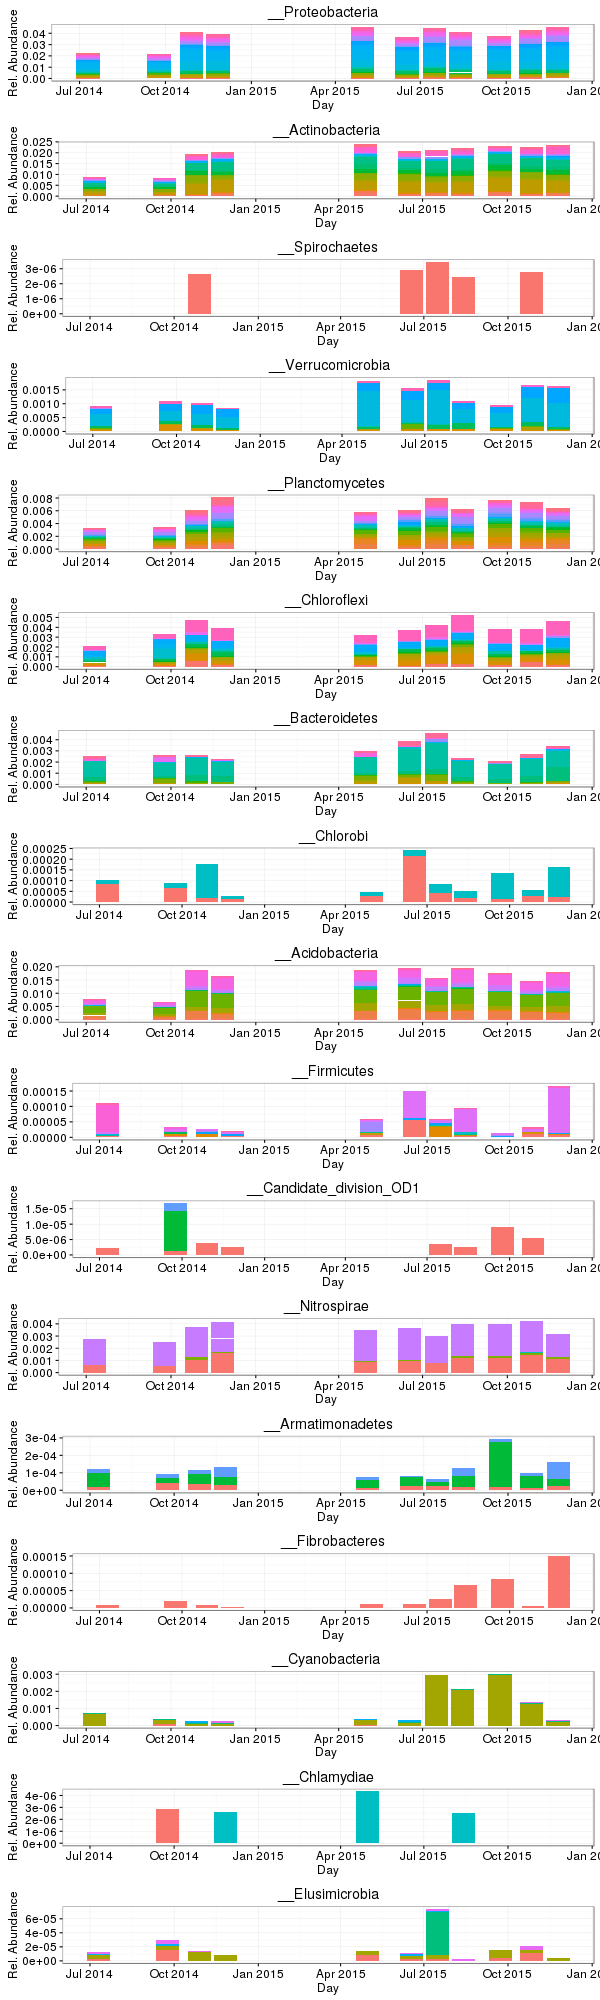

In [38]:
%%R -w 600 -h 2000

#scheme = iwanthue()

df.cell.N = filter(minP.df, Land_Management == 'NTH', Substrate == '13C')
phyla = unique(df.cell.N$Rank2)
#t = "13CCPS"
bulk.df$Rank2 = gsub("c__", "", bulk.df$Rank2)

filt = df.cell.N %>% 
    filter(Rank2 %in% phyla)# %>%
    #arrange(Rank3, `Relative Abundance`)

d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)

d$Sample_Date = as.POSIXct(strptime(d$Sample_Date, format = "%m/%d/%y"))


plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = Sample_Date, y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = FALSE)# guide_legend(ncol = 2))
    
    p = p + theme_bw() 
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
   # p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
    #                           list(a = t, b = r)))
    p = p + ggtitle(r)
    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))

In [15]:
%%R
pdf("../data/figs/abund_v_time_phyla.pdf", h = 15, w = 10)
do.call(grid.arrange, c(plots.13CCPS, list(ncol=1, nrow = 7)))
dev.off()


png 
  2 


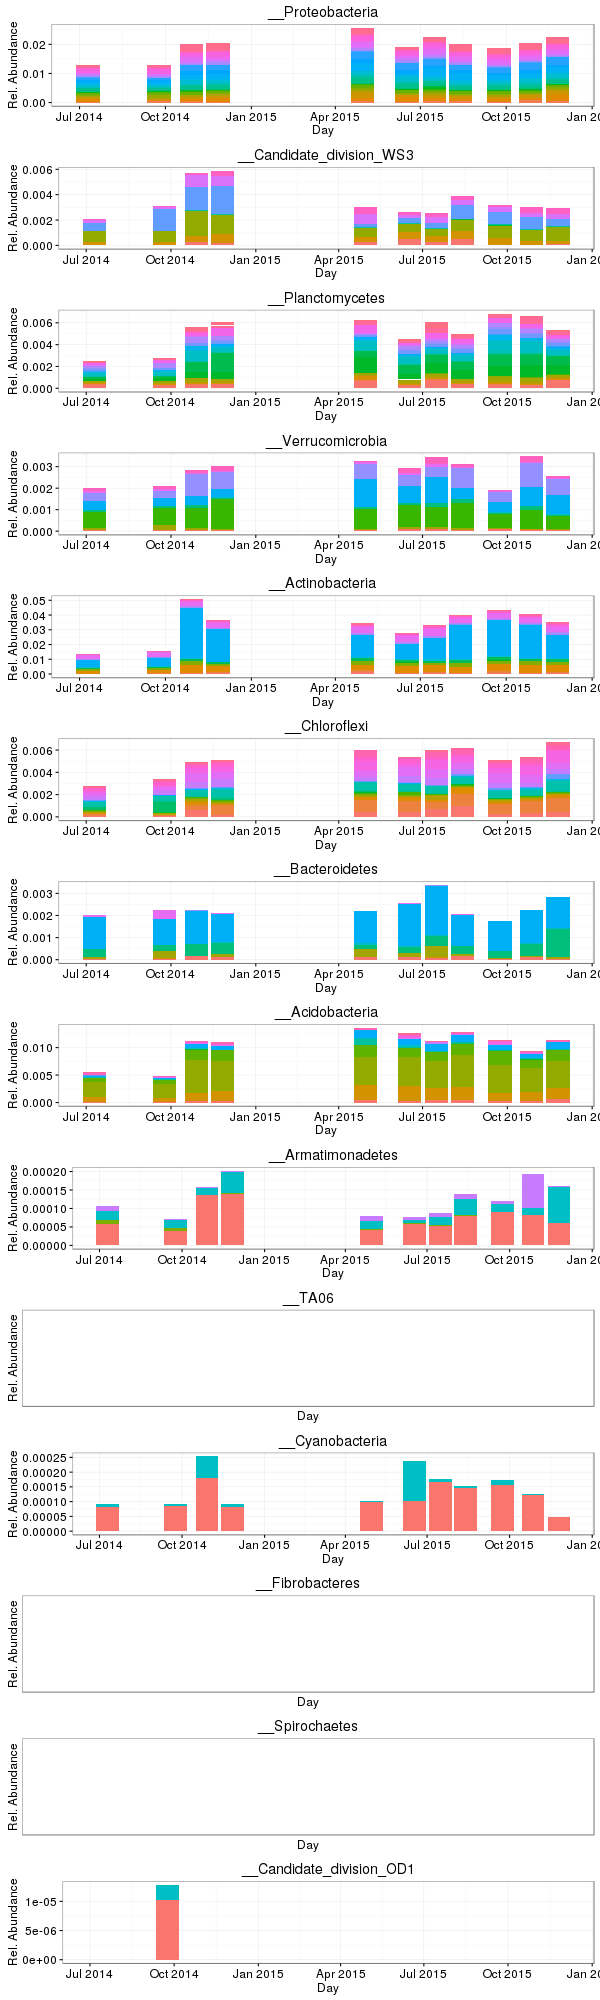

In [39]:
%%R -w 600 -h 2000

#scheme = iwanthue()

df.cell.N = filter(minP.df, Land_Management == 'PTH', Substrate == '13C')
phyla = unique(df.cell.N$Rank2)
#t = "13CCPS"
bulk.df$Rank2 = gsub("c__", "", bulk.df$Rank2)

filt = df.cell.N %>% 
    filter(Rank2 %in% phyla)# %>%
    #arrange(Rank3, `Relative Abundance`)

d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)

d$Sample_Date = as.POSIXct(strptime(d$Sample_Date, format = "%m/%d/%y"))


plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = Sample_Date, y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = FALSE)# guide_legend(ncol = 2))
    
    p = p + theme_bw() 
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
   # p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
    #                           list(a = t, b = r)))
    p = p + ggtitle(r)
    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))

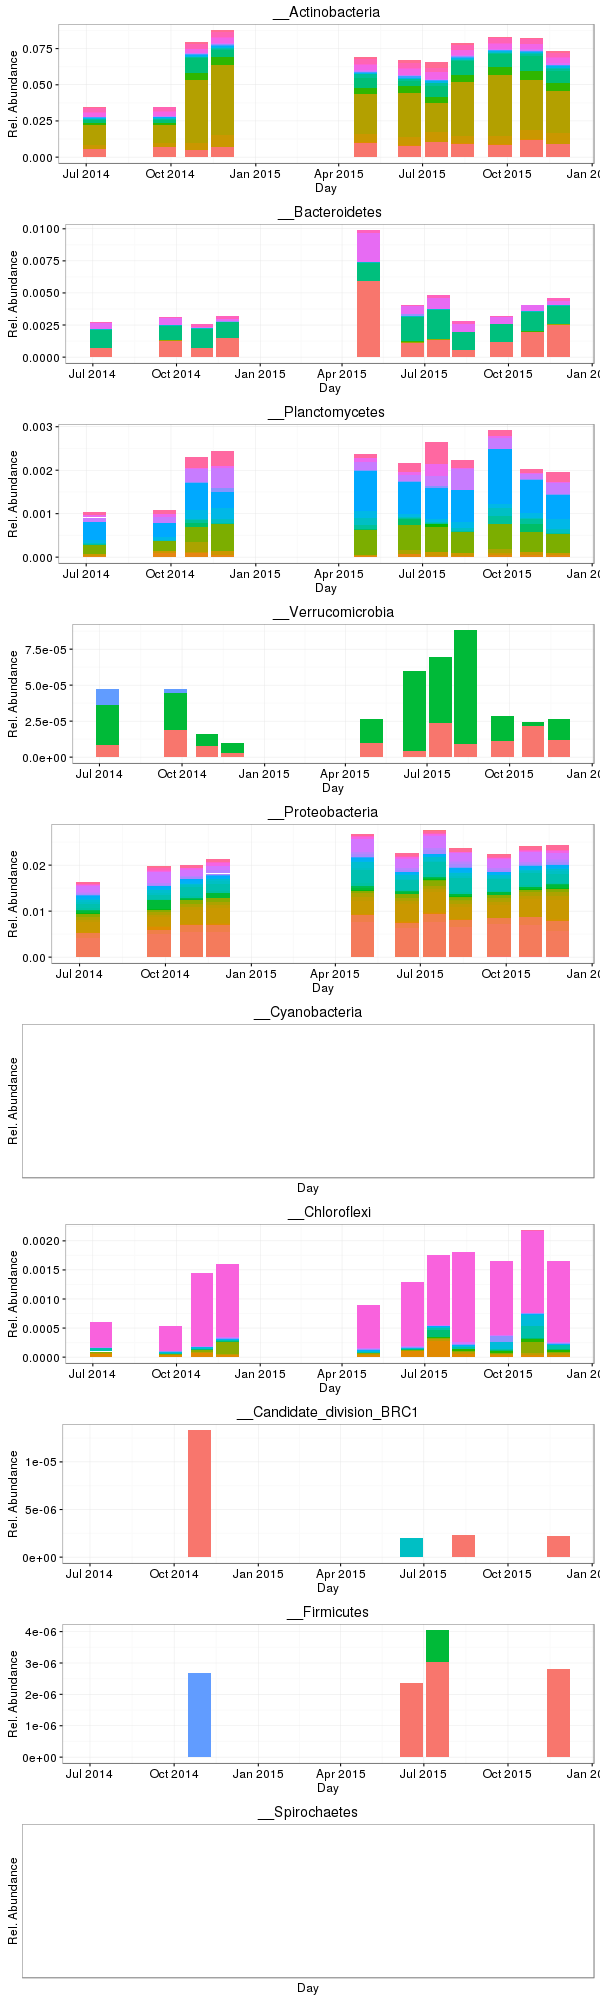

In [40]:
%%R -w 600 -h 2000

#scheme = iwanthue()

df.cell.N = filter(minP.df, Land_Management == 'NTH', Substrate == '13X')
phyla = unique(df.cell.N$Rank2)
#t = "13CCPS"
bulk.df$Rank2 = gsub("c__", "", bulk.df$Rank2)

filt = df.cell.N %>% 
    filter(Rank2 %in% phyla)# %>%
    #arrange(Rank3, `Relative Abundance`)

d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)

d$Sample_Date = as.POSIXct(strptime(d$Sample_Date, format = "%m/%d/%y"))


plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = Sample_Date, y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = FALSE)# guide_legend(ncol = 2))
    
    p = p + theme_bw() 
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
   # p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
    #                           list(a = t, b = r)))
    p = p + ggtitle(r)
    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))

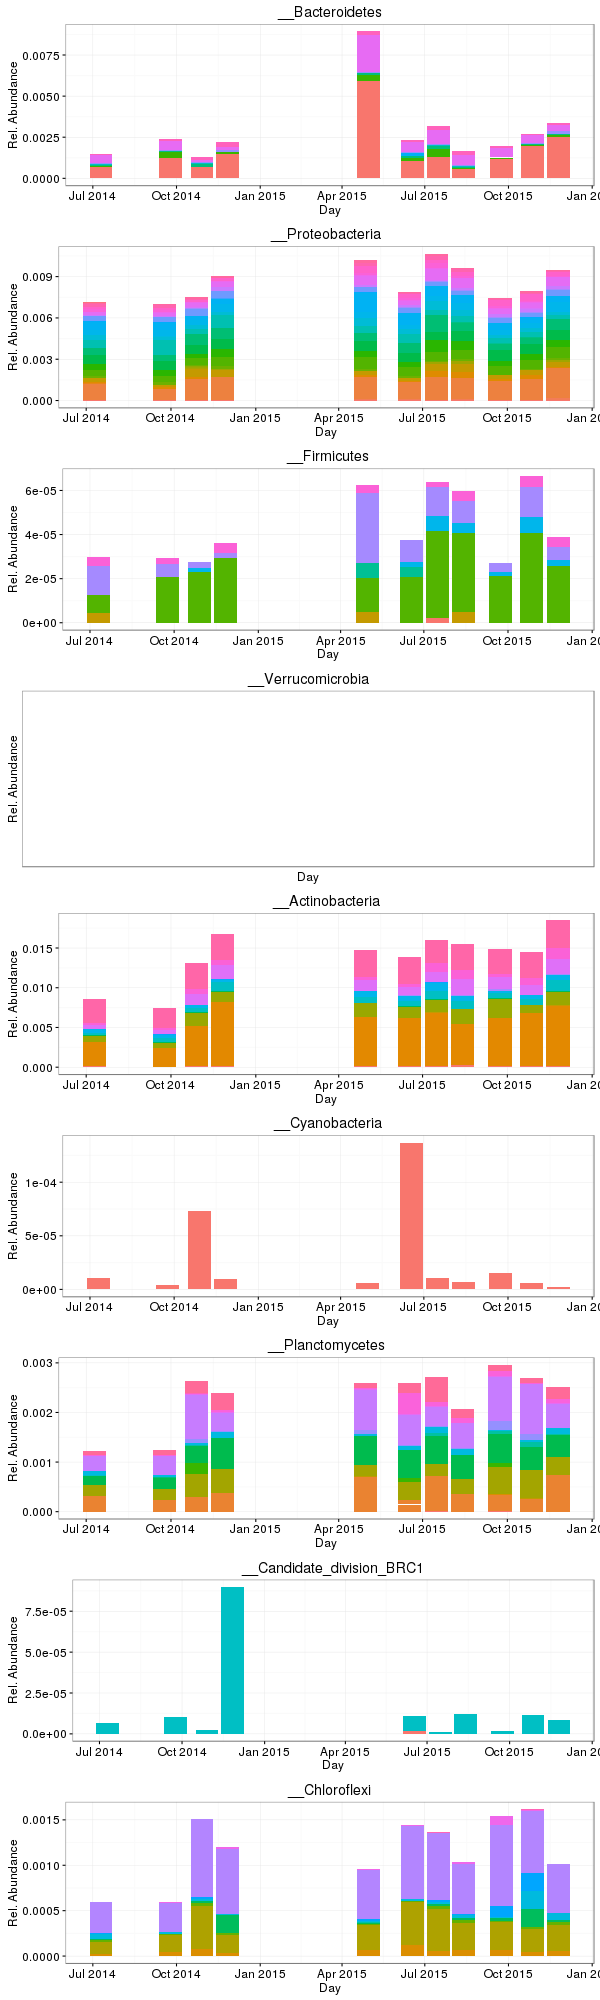

In [41]:
%%R -w 600 -h 2000

#scheme = iwanthue()

df.cell.N = filter(minP.df, Land_Management == 'PTH', Substrate == '13X')
phyla = unique(df.cell.N$Rank2)
#t = "13CCPS"
bulk.df$Rank2 = gsub("c__", "", bulk.df$Rank2)

filt = df.cell.N %>% 
    filter(Rank2 %in% phyla)# %>%
    #arrange(Rank3, `Relative Abundance`)

d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)

d$Sample_Date = as.POSIXct(strptime(d$Sample_Date, format = "%m/%d/%y"))


plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = Sample_Date, y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = FALSE)# guide_legend(ncol = 2))
    
    p = p + theme_bw() 
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
   # p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
    #                           list(a = t, b = r)))
    p = p + ggtitle(r)
    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))

In [22]:
%%R
d %>% group_by(Rank3) %>% summarise(totalRA = sum(`Relative Abundance`))

Source: local data frame [7 x 2]

            Rank3      totalRA
            (chr)        (dbl)
1  Agaricomycetes 0.0004120879
2 Dothideomycetes 0.0009939377
3   Leotiomycetes 0.0028687406
4  Orbiliomycetes 0.1165277494
5 Saccharomycetes 0.0001696578
6 Sordariomycetes 0.6946449189
7    unidentified 0.0654093263


In [17]:
FileLink("figs/abund_v_time_phyla.pdf")


/home/chantal/FungalSIP/BulkCommunity/figs/abund_v_time_phyla.pdf

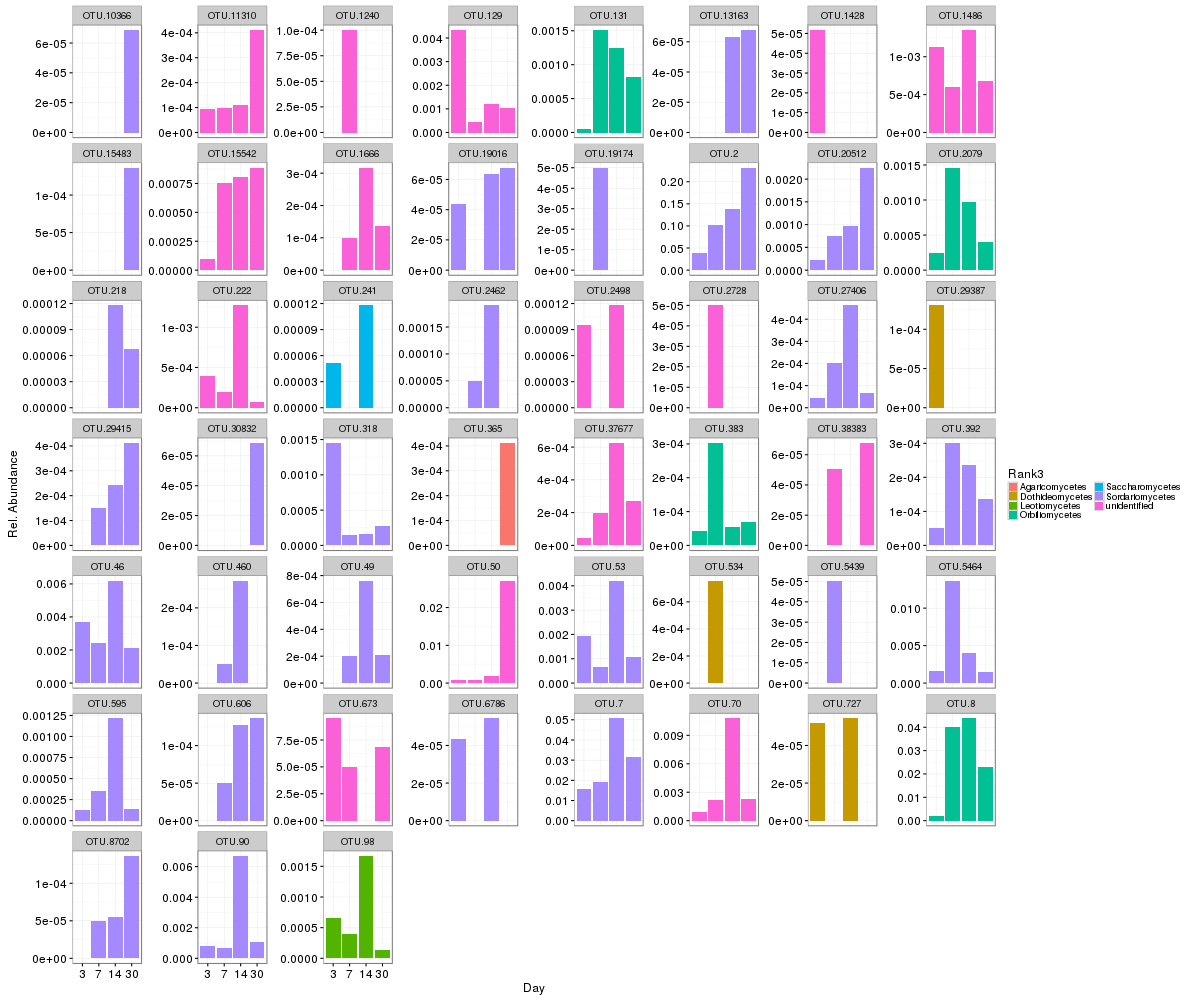

In [33]:
 %%R -w 1200 -h 1000
    
    d2= filter(d, `Relative Abundance` > 0)
    
    p = ggplot(d2, aes(x = factor(Day), y = `Relative Abundance`, fill = Rank3))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
  #  p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
   #                            list(a = t, b = r)))
    
    p = p + facet_wrap(~OTU, scales = "free_y")

    p

In [18]:
%%R 
head(d)

Source: local data frame [6 x 6]
Groups: OTU, Rank2, Rank3, Rank4 [2]

        OTU         Rank2           Rank3          Rank4   Day
      (chr)        (fctr)           (chr)         (fctr) (int)
1 OTU.10366 p__Ascomycota Sordariomycetes o__Sordariales     3
2 OTU.10366 p__Ascomycota Sordariomycetes o__Sordariales     7
3 OTU.10366 p__Ascomycota Sordariomycetes o__Sordariales    14
4 OTU.10366 p__Ascomycota Sordariomycetes o__Sordariales    30
5 OTU.10786 p__Ascomycota Sordariomycetes o__Sordariales     3
6 OTU.10786 p__Ascomycota Sordariomycetes o__Sordariales     7
Variables not shown: Relative Abundance (dbl)
